In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
import kaggle

kaggle.api.authenticate()

In [4]:
!kaggle datasets download -d 'fpeccia/weed-detection-in-soybean-crops'

 99% 2.35G/2.37G [00:50<00:00, 34.7MB/s]
100% 2.37G/2.37G [00:50<00:00, 50.0MB/s]


In [0]:
!mkdir '../data'

In [0]:
!unzip --qq 'weed-detection-in-soybean-crops.zip' -d '../data'

In [0]:
#os.listdir(defaultPath+'/broadleaf')
!rm -rf '../data/dataset/dataset'

In [8]:
!pip3 install torch torchvision

In [9]:
!nvidia-smi

Sat Oct 19 22:34:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets.folder import IMG_EXTENSIONS
from torch.utils.data.sampler import SubsetRandomSampler
plt.ion()   # interactive mode
import os
defaultPath='../data/dataset'

In [11]:
os.listdir('../data/dataset')

['soil', 'grass', 'soybean', 'broadleaf']

In [12]:
 for x in os.listdir('../data/dataset'):
   print(x)

soil
grass
soybean
broadleaf


In [13]:
! ls -ltr '../data/dataset/soil/10.tif'

-rw-r--r-- 1 root root 60624 Oct  6 01:28 ../data/dataset/soil/10.tif


In [14]:
#len(os.listdir('../data/dataset/soil'))+len(os.listdir('../data/dataset/soybean'))+len(os.listdir('../data/dataset/broadleaf'))+len(os.listdir('../data/dataset/grass'))
datasets.ImageFolder('../data/dataset/')

Dataset ImageFolder
    Number of datapoints: 15336
    Root location: ../data/dataset/

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

valid_size=0.2
data_dir = '../data/dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir),transform=data_transforms)
test_datasets = datasets.ImageFolder(os.path.join(data_dir),transform=data_transforms)

num_train = len(train_datasets)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx,test_idx=indices[split:],indices[:split]
trainSampler=SubsetRandomSampler(train_idx)
testSampler=SubsetRandomSampler(test_idx)
trainloaders = torch.utils.data.DataLoader(train_datasets, batch_size=4,sampler=trainSampler,num_workers=4)
testloaders = torch.utils.data.DataLoader(train_datasets, batch_size=4,sampler=testSampler,num_workers=4)
 #             for x in ['train', 'val']}
#test_ds, valid_ds = torch.utils.data.random_split(dataloaders.dataset, (12000, 3337))

class_names = train_datasets.classes
#dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
trainloaders.dataset

Dataset ImageFolder
    Number of datapoints: 15336
    Root location: ../data/dataset
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:

dataset_sizes = {'train':len(train_idx),'val':len(test_idx)}
dataset_sizes

{'train': 12269, 'val': 3067}

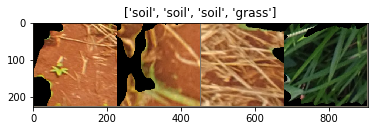

In [18]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes =next(iter(trainloaders))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloaders=trainloaders
                model.train()  # Set model to training mode
            else:
                dataloaders=testloaders
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloaders):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [21]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.7MB/s]


In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.2951 Acc: 0.9046
val Loss: 0.2517 Acc: 0.9123

Epoch 1/4
----------
train Loss: 0.1836 Acc: 0.9471
val Loss: 0.0835 Acc: 0.9674

Epoch 2/4
----------
train Loss: 0.1488 Acc: 0.9598
val Loss: 0.0500 Acc: 0.9827

Epoch 3/4
----------
train Loss: 0.1095 Acc: 0.9694
val Loss: 0.0345 Acc: 0.9876

Epoch 4/4
----------
train Loss: 0.1038 Acc: 0.9738
val Loss: 0.0901 Acc: 0.9684

Training complete in 16m 38s
Best val Acc: 0.987610


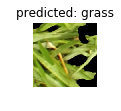

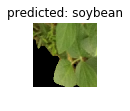

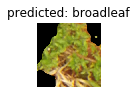

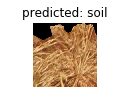

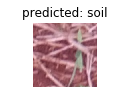

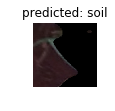

In [23]:
visualize_model(model_ft)

In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4522 Acc: 0.8355
val Loss: 0.1418 Acc: 0.9491

Epoch 1/4
----------
train Loss: 0.4031 Acc: 0.8598
val Loss: 0.1227 Acc: 0.9570

Epoch 2/4
----------
train Loss: 0.3670 Acc: 0.8711
val Loss: 0.1769 Acc: 0.9394

Epoch 3/4
----------
train Loss: 0.3750 Acc: 0.8698
val Loss: 0.1332 Acc: 0.9605

Epoch 4/4
----------
train Loss: 0.3736 Acc: 0.8724
val Loss: 0.0985 Acc: 0.9684

Training complete in 8m 3s
Best val Acc: 0.968373


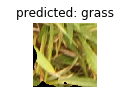

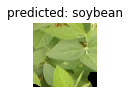

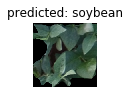

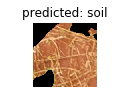

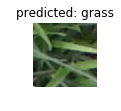

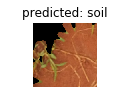

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()